# 15分足データの基本分析

- 上昇確率

## 結果・考察
- 15分足では、全体での上昇確率43%、不変確率16%、下落確率42%
    - 1分足では不変確率が39%と高かったが時間枠が伸びるほど不変確率は下がる。
- 1年毎で見ると、2003～2006は値動きが小さかったようだがそれ以外の期間では上昇確率は40%以上になっている。
    - 戦略のバックテストの時に、特に値動きの小さい2004～2006または2005の一年間はレンジ相場の代表として使えるかもしれない。

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale
from joblib import Parallel, delayed
from functools import reduce

import finalib as fl
import finalib.mine as mi
import ta

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# データ読み込み

In [26]:
# 生データ
sp_dir = 'data/e-mini-sp500-200530'
df_sp_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-15min.csv')

# 月次データ（1年ごとの価格変化を見るため）
#df_spm_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-monthly.csv')

In [47]:
# 月次データ（1年ごとの価格変化を見るため）
df_spm_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-monthly.csv')

In [27]:
df_sp_raw.head(2)

,Date,Time,Open,High,Low,Close,Up,Down
0,09/11/1997,04:45,1082.25,1082.25,1079.75,1079.75,5,0
1,09/11/1997,06:00,1079.25,1079.25,1079.25,1079.25,1,0


In [28]:
df_sp_raw.tail(2)

,Date,Time,Open,High,Low,Close,Up,Down
494261,05/29/2020,16:45,3053.00,3058.25,3051.00,3056.50,4965,5882
494262,05/29/2020,17:00,3056.25,3058.00,3055.25,3057.25,2729,2808


# 分析用データ作成

In [45]:
df = df_sp_raw.copy()

# DateTime列を追加
df['DT'] = (df['Date'] + '-' + df['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))

# 値動き（終値 - 始値）列を追加
df['CODiff'] = df['Close'] - df['Open']

# 年の列を追加
df['year'] = df['DT'].map(lambda d: d.year)

# 年の順序付け
year_type = CategoricalDtype(categories=range(df['year'].min(), df['year'].max()+1), ordered=True)
df['year'] = df['year'].astype(year_type)

In [46]:
# 上昇、不変、下落
df['isUp'] = df['CODiff'] > 0
df['isFlat'] = df['CODiff'] == 0
df['isDown'] = df['CODiff'] < 0

### 年次データの作成（月次データを1年ごとに平均する）

In [51]:
dfm = df_spm_raw.copy()
dfm['DT'] = (dfm['Date'] + '-' + dfm['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
dfm['year'] = dfm['DT'].map(lambda x: x.year)

dfm_by_year = dfm.groupby('year').mean()

# 全期間での15分足データの上昇確率

In [53]:
print(f"P(UP) = {df['isUp'].sum()} / {df.shape[0]} = {df['isUp'].sum() / df.shape[0] * 100}%")
print(f"P(FLAT) = {df['isFlat'].sum()} / {df.shape[0]} = {df['isFlat'].sum() / df.shape[0] * 100}%")
print(f"P(DOWN) = {df['isDown'].sum()} / {df.shape[0]} = {df['isDown'].sum() / df.shape[0] * 100}%")
df['isUp'].sum() + df['isFlat'].sum() + df['isDown'].sum() == df.shape[0]

P(UP) = 211672 / 494263 = 42.8257830345383%
P(FLAT) = 76762 / 494263 = 15.530598082397429%
P(DOWN) = 205829 / 494263 = 41.643618883064285%


True

# 1年ごとの上昇確率推移

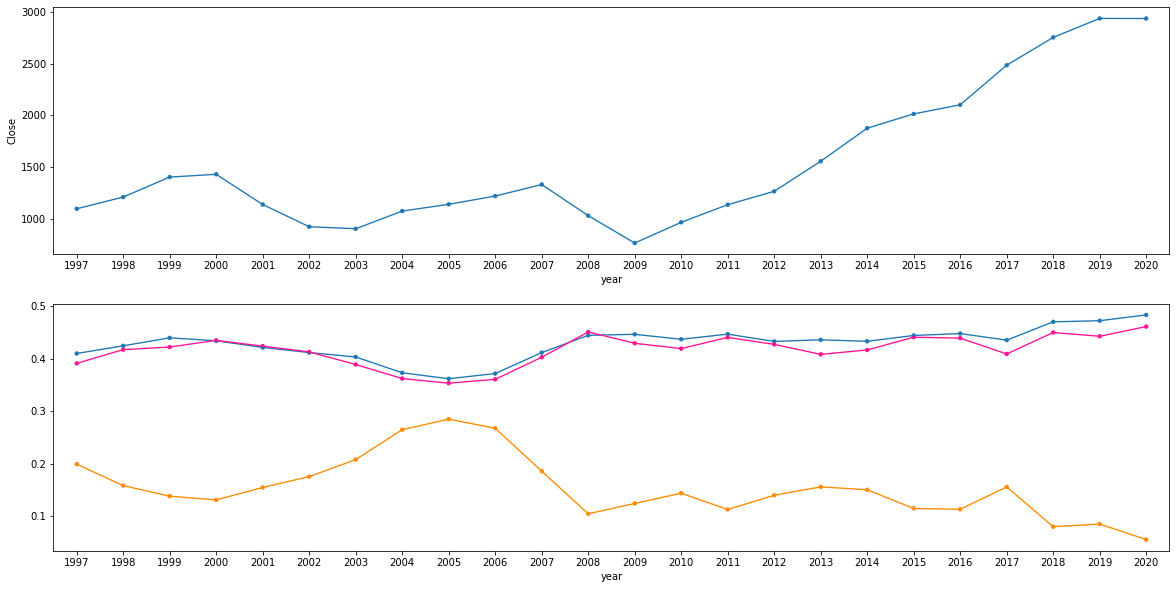

In [54]:
df_by_year = df.groupby('year')[['isUp', 'isFlat', 'isDown']].sum()
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.pointplot(dfm_by_year.index, dfm_by_year['Close'], scale=0.5, ax=ax[0])
sns.pointplot(df_by_year.index, df_by_year['isUp'] / df['year'].value_counts().sort_index(), scale=0.5, ax=ax[1])
sns.pointplot(df_by_year.index, df_by_year['isFlat'] / df['year'].value_counts().sort_index(), scale=0.5, ax=ax[1], color='darkorange')
sns.pointplot(df_by_year.index, df_by_year['isDown'] / df['year'].value_counts().sort_index(), scale=0.5, ax=ax[1], color='deeppink')

,isUp,isFlat,isDown
year,,,
1997,1718.0,833.0,1639.0
1998,6184.0,2299.0,6077.0
1999,6557.0,2053.0,6295.0
2000,6506.0,1957.0,6518.0
2001,8017.0,2934.0,8065.0
2002,8963.0,3810.0,8991.0
2003,9003.0,4632.0,8682.0
2004,8729.0,6188.0,8472.0
2005,8460.0,6656.0,8261.0
